In [2]:
#using PyPlot
using PGFPlots
include("chess.jl")  # This handles the board position and moves

makeMove! (generic function with 1 method)

In [3]:
# Reward function
# Gives reward for checkmate +50, penalty for stalemate -10, small gradient on black king to sides of board
function reward(state::Board, gameOver::Bool)
    WIN = 50
    DRAW = -10    
    if(length(state.piecesWhite) == 1) #draw
        return DRAW
    end
    if(gameOver == true)
        if(blackInCheck(state))
            return WIN
        else
            return DRAW
        end
    end
    
    kingPos = state.piecesBlack["King"]
    return 0 #.1*max(abs(kingPos[1]-4.5),abs(kingPos[2]-4.5)) # encourage pushing king away from center
end

# Outputs the state as string for hashmap to work properly
function board2str(state::Board)
    string = "K$(state.piecesWhite["King"])R$(state.piecesWhite["Rook"])K$(state.piecesBlack["King"])"
end

# returns current position quadrant
function findQuadrant(pos::(Int64,Int64))
    if(pos[1]<5)
        if(pos[2]<5)
            return 1
        else
            return 4 
        end
    else
        if(pos[2]<5)
            return 2 
        else
            return 3
        end
    end
end

function flipPiece(currQ::Int64, desiredQ::Int64 = 1)
    
end

# Takes in board state and outputs board hash-string rotated into the desired quadrant and the original quadrant info
function flipBoard(origState::Board, desiredQuadrant::Int64 = 1)
    state = deepcopy(origState)
    kPos = state.piecesWhite["King"]
    quad = findQuadrant(kPos)
#     println("quadrant = $quad")
    
    if(quad == 1)
        return state, quad
    elseif (quad == 2)
        # Flip x coord
        for (piece,pos) in state.piecesWhite
            state.piecesWhite[piece] = (9-pos[1],pos[2])
        end
        for (piece,pos) in state.piecesBlack
            state.piecesBlack[piece] = (9-pos[1],pos[2])
        end        
        return state, quad;
    elseif (quad == 3)
        # Flip x coord and y coord
        for (piece,pos) in state.piecesWhite
            state.piecesWhite[piece] = (9-pos[1],9-pos[2])
        end
        for (piece,pos) in state.piecesBlack
            state.piecesBlack[piece] = (9-pos[1],9-pos[2])
        end        
        return state, quad;
    elseif (quad == 4)
        # Flip y coord
        for (piece,pos) in state.piecesWhite
            state.piecesWhite[piece] = (pos[1],9-pos[2])
        end
        for (piece,pos) in state.piecesBlack
            state.piecesBlack[piece] = (pos[1],9-pos[2])
        end        
        return state, quad;
    end
end

function flipAction(action::(String,(Int64,Int64)),quad::Int64)
#     flippedAction = deepcopy(action) 
    
    piece = action[1]
    x = action[2][1]
    y = action[2][2]
    
#     flippedAction = (String,(Int64,Int64))
    if(quad == 1)
        flippedAction = deepcopy(action)
    elseif(quad == 2)
        flippedAction = (piece,(9-x,y)) 
    elseif(quad == 3)
        flippedAction = (piece,(9-x,9-y))
    elseif(quad == 4)
        flippedAction = (piece,(x,9-y)) 
    end
    
    return flippedAction
end


flipAction (generic function with 1 method)

In [4]:
state = randomState()
println(state)
stateFlip, quad = flipBoard(state)

println(state)
println(stateFlip)
flipAction(("King",(1,3)),4)

Board(["Rook"=>(5,5),"King"=>(8,5)],["King"=>(6,8)])
Board(["Rook"=>(5,5),"King"=>(8,5)],["King"=>(6,8)])
Board(["Rook"=>(4,4),"King"=>(1,4)],["King"=>(3,1)])


("King",(1,6))

In [62]:
moveCount = 0
α = .1 # learning rate
γ = .7 # horizon
λ = .7 # eligibility trace was .9 originally


state = randomState();
WHITE = 1;
BLACK = 2;

# Initialize data-structures
Q = Dict{String,Dict{(String,(Int64,Int64)),Float64}}()
stateHistory = Board[]
actionHistory = (String,(Int64,Int64))[]
gameCount = 0;

NUMGAMES = 100000;
wins = zeros(NUMGAMES);
freqWin = Int64[];
freqDraw = Int64[];

symmetryDecomp = true

while (gameCount < NUMGAMES)    
    # Varies epsilon exponentially from .3 to .75 as we play games!
    ϵ = .2*exp(gameCount* log(2.5)/NUMGAMES)  
    
    quad = 1; # default    
    flippedState,quad =  flipBoard(state,1)
#     flippedState = deepcopy(state)
    
    state_str = board2str(flippedState)
    
    
    movesWhite = moves(flippedState,WHITE)
    
    # Add state/action pairs to Q(s,a) dictionary
    if(!haskey(Q,state_str))
        Q[state_str] = [a => 0.0 for a in movesWhite]
    end
    
    # Exploration strategy: epsilon-greedy
    if(rand() < ϵ) # Optimal Q
        flippedAction = reduce((x, y) -> Q[state_str][x] >= Q[state_str][y] ? x : y, keys(Q[state_str]))
    else # random explore
        flippedAction = movesWhite[rand(1:end)]
    end
    
    value = Q[state_str][flippedAction]

    action = flipAction(flippedAction,quad)
#     action = deepcopy(flippedAction)
    
    # Save the flipped state/action pair for eligibility traces
    push!(stateHistory,deepcopy(flippedState))
    push!(actionHistory,deepcopy(flippedAction))
    
    # Updates the game state with the "real" state and action
    makeMove!(state, action, WHITE)
    
    # Opponent moves
    opponentMoves = moves(state,BLACK)
    
    # opponent strategy -- random
    gameOver = false
    
    if(length(opponentMoves)>0)
        canCapture = false;
        # 1 step look-ahead optimal decision
        for m in opponentMoves
            if(m[2] == state.piecesWhite["Rook"])
                responseAction = m
                canCapture = true;
            end
        end
        if(!canCapture)
            responseAction = opponentMoves[rand(1:end)]
        end
        makeMove!(state, responseAction, BLACK)
    end
    
    if(length(opponentMoves) == 0 || length(state.piecesWhite) == 1)
        gameOver = true
    end
    # state = s_{t+1}
    # reward = r_{t}
    r = reward(state, gameOver)

    if(gameOver || moveCount > 2000)
        if(gameCount%1000 == 0)
            println("gameCount = $gameCount")
        end

        δ = (r + γ*r- Q[state_str][flippedAction])
        Q[state_str][flippedAction] += α * δ
        
        # Eligibility trace update when game is won
        if(r >= 20)
            for i = 1:length(stateHistory)
                s_old = pop!(stateHistory) 
                a_old = pop!(actionHistory)            
                Q[board2str(s_old)][a_old] += α * λ^i * δ
            end
            wins[gameCount] = 1;
            push!(freqWin,gameCount);
#             println("Won in $moveCount moves $(board2str(state))")
        else
            push!(freqDraw,gameCount)
        end
        state = randomState()
        moveCount = 0
        gameCount +=1
        empty!(stateHistory)
        empty!(actionHistory)
        continue
    end

    # Q-learning update
    s_t_next = board2str(flippedState)
    val = 0;
    if(haskey(Q,s_t_next))
        val = maximum(values(Q[s_t_next]))
    end
    δ = (r + γ*val - Q[state_str][flippedAction])
    Q[state_str][flippedAction] +=  α * δ
    if(val > 20)
        for i = 1:length(stateHistory)
            s_old = pop!(stateHistory) 
            a_old = pop!(actionHistory)            
            Q[board2str(s_old)][a_old] += α * λ^i * δ
        end
    end
    
    moveCount += 1    
end

println(sum(wins))

gameCount = 0
gameCount = 1000
gameCount = 2000
gameCount = 3000
gameCount = 4000
gameCount = 5000
gameCount = 6000
gameCount = 7000
gameCount = 8000
gameCount = 9000
gameCount = 10000
gameCount = 11000
gameCount = 12000
gameCount = 13000
gameCount = 14000
gameCount = 15000
gameCount = 16000
gameCount = 17000
gameCount = 18000
gameCount = 19000
gameCount = 20000
gameCount = 21000
gameCount = 22000
gameCount = 23000
gameCount = 24000
gameCount = 25000
gameCount = 26000
gameCount = 27000
gameCount = 28000
gameCount = 29000
gameCount = 30000
gameCount = 31000
gameCount = 32000
gameCount = 33000
gameCount = 34000
gameCount = 35000
gameCount = 36000
gameCount = 37000
gameCount = 38000
gameCount = 39000
gameCount = 40000
gameCount = 41000
gameCount = 42000
gameCount = 43000
gameCount = 44000
gameCount = 45000
gameCount = 46000
gameCount = 47000
gameCount = 48000
gameCount = 49000
gameCount = 50000
gameCount = 51000
gameCount = 52000
gameCount = 53000
gameCount = 54000
gameCount = 55000
gameC

In [65]:
# test trained model
gameCnt = 0;
moveCnt = 0;

WHITE = 1
BLACK = 2

winCnt = 0
drawCnt = 0
notObserved = 0;
observed = 0;

state = randomState()
gameOver = false;
moveDistribution = Int64[];

while gameCnt < 1000
    if(gameOver)
        state = randomState()
    end
    flippedState,quad =  flipBoard(state)
#     flippedState = deepcopy(state)
#     quad = 1
    state_str  = board2str(flippedState)
    
    if(haskey(Q,state_str))
        flippedAction = reduce((x, y) -> Q[state_str][x] >= Q[state_str][y] ? x : y, keys(Q[state_str]))
        action = flipAction(flippedAction,quad)
        observed +=1
    else
        wMoves = moves(state,WHITE)
        action = wMoves[rand(1:end)]
        notObserved +=1
    end 

    makeMove!(state,action,WHITE)
    gameOver = false;
    
    opponentMoves = moves(state,BLACK)
    
    if(length(opponentMoves) > 0 )
        makeMove!(state,opponentMoves[rand(1:end)],BLACK)
    end

    if(length(opponentMoves) == 0 || length(state.piecesWhite) == 1)
        gameOver = true
    end
    

    if(gameOver || moveCnt > 100)
        gameOver = true
        gameCnt += 1
        if(blackInCheck(state)) # black in check
            winCnt+=1
            push!(moveDistribution,moveCnt)
        else
            drawCnt+=1
        end
        moveCnt = 0;
        continue
    end
    
    moveCnt += 1
end

println("wins: $winCnt")
println("draws: $drawCnt")
println("observed: $observed")
println("not observed: $notObserved")

wins: 998
draws: 2
observed: 18196
not observed: 0


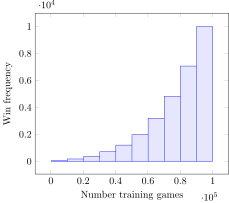

In [66]:
a1 = Axis(Plots.Histogram(freqWin,bins=10,cumulative=true),xlabel="Number training games", ylabel="Win frequency")
# a2 = Axis(Plots.Histogram(freqDraw,bins=10,cumulative=true),xlabel="Number training games", ylabel="Draw frequency")
# save("win_frequency_training.pdf",a1)
# save("draw_frequency_training.pdf",a2)

plot(a1)
# winCnt/(winCnt+drawCnt)

In [68]:
a_dist = Axis(Plots.Histogram(moveDistribution,bins=100),xlabel="Number of moves",ylabel="Win frequency")
save("win_move_distributionv2.pdf",a_dist)
# median(moveDistribution)

In [135]:
# s = Board(["Rook"=>(6,7),"King"=>(4,4)],["King"=>(2,2)])
# s = randomState()
println(s)
state_str = board2str(s)
a = reduce((x, y) -> Q[state_str][x] >= Q[state_str][y] ? x : y, keys(Q[state_str]))
println(a)
#
makeMove!(s,a,1)

Board(["Rook"=>(2,6),"King"=>(4,4)],["King"=>(1,4)])
("King",(4,5))


(4,5)

In [134]:
makeMove!(s,("King",(1,4)),2)
s

Board(["Rook"=>(2,6),"King"=>(4,4)],["King"=>(1,4)])